# Import Library

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import time

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Nhóm 1/2 Bài tập trên lớp/Thực hành Final/Data processed/final_dataset_improved.csv'

df = pd.read_csv(path)
df.head()

,id,name,num_users,total_cmt,positive,negative,neutral,average_completion_rate,number of resources,rank_binned,course_classification
0,C_655852,series of courses-completed courses without re...,48,0.0,0.0,0.0,0.0,0.648872,162,9.000000,Dissatisfied
1,C_655850,series of classes - class has not started yet,47,0.0,0.0,0.0,0.0,0.648872,91,1.000000,Neutral
2,C_654554,series of courses - now starting,47,0.0,0.0,0.0,0.0,0.648872,99,4.481596,Dissatisfied
3,C_654506,series of courses - the course has ended and t...,47,0.0,0.0,0.0,0.0,0.648872,3,4.481596,Dissatisfied
4,C_629558,medical immunology and pathogen biology,48,0.0,0.0,0.0,0.0,0.648872,91,4.481596,Dissatisfied


In [ ]:
df['course_classification'].value_counts()

,count
course_classification,
Dissatisfied,876
Neutral,585
Satisfied,526
Very dissatisfied,461
Very satisfied,374


In [ ]:
df['course_classification'] = df['course_classification'].map({'Very dissatisfied': 0, 'Dissatisfied': 1, 'Neutral': 2, 'Satisfied': 3, 'Very satisfied': 4})
df.head()

,id,name,num_users,total_cmt,positive,negative,neutral,average_completion_rate,number of resources,rank_binned,course_classification
0,C_655852,series of courses-completed courses without re...,48,0.0,0.0,0.0,0.0,0.648872,162,9.000000,1
1,C_655850,series of classes - class has not started yet,47,0.0,0.0,0.0,0.0,0.648872,91,1.000000,2
2,C_654554,series of courses - now starting,47,0.0,0.0,0.0,0.0,0.648872,99,4.481596,1
3,C_654506,series of courses - the course has ended and t...,47,0.0,0.0,0.0,0.0,0.648872,3,4.481596,1
4,C_629558,medical immunology and pathogen biology,48,0.0,0.0,0.0,0.0,0.648872,91,4.481596,1


In [ ]:
df['course_classification'].value_counts().sort_index()

,count
course_classification,
0,461
1,876
2,585
3,526
4,374


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2822 entries, 0 to 2821
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       2822 non-null   object 
 1   name                     2822 non-null   object 
 2   num_users                2822 non-null   int64  
 3   total_cmt                2822 non-null   float64
 4   positive                 2822 non-null   float64
 5   negative                 2822 non-null   float64
 6   neutral                  2822 non-null   float64
 7   average_completion_rate  2822 non-null   float64
 8   number of resources      2822 non-null   int64  
 9   rank_binned              2822 non-null   float64
 10  course_classification    2822 non-null   int64  
dtypes: float64(6), int64(3), object(2)
memory usage: 242.6+ KB


# Data Preparation

In [ ]:
X = df.drop(columns=['id',
                     'name',
                     'course_classification',])
y = df['course_classification']

X.shape

(2822, 8)

Bộ dữ liệu được chia thành 3 tập là train, validation, test theo tỷ lệ 8:1:1

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
X_train.shape, X_test.shape, X_valid.shape

((2257, 8), (282, 8), (283, 8))

In [ ]:
scaler = PowerTransformer()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [ ]:
# Các hàm xác định và in độ đo đánh giá

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    return accuracy, precision, recall, f1

def plot_confusion_matrix(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    plt.figure(figsize=(8, 6))
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Confusion Matrix for {model}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

def print_acc(model_name, acc, prec, rec, f1):
    print(f'{model_name}\n - Accuracy: {acc},\n - Precision: {prec},\n - Recall: {rec},\n - F1 Score: {f1}\n')

# Support Vector Machine

Support Vector Machine (SVM) là một thuật toán học máy thường được sử dụng cho các bài toán phân loại và hồi quy. Mục tiêu chính của SVM là tìm ra một siêu phẳng tối ưu để phân tách các lớp dữ liệu một cách hiệu quả nhất. Với khả năng áp dụng trên cả dữ liệu tuyến tính và phi tuyến, SVM được đánh giá cao nhờ tính linh hoạt và khả năng tổng quát hóa.
Để tối ưu hóa hiệu suất, SVM cho phép cấu hình thông qua nhiều tham số. Một số tham số quan trọng bao gồm:

1.   C (Regularization Parameter):

*   Ý nghĩa: Đây là tham số điều chỉnh độ mạnh của việc regularization.
*   Cách hoạt động: Độ mạnh của regularization tỷ lệ nghịch với giá trị của C. Khi C lớn, thuật toán cố gắng tối thiểu hóa lỗi huấn luyện (overfitting). Ngược lại, giá trị nhỏ giúp tăng độ regularization, ưu tiên một siêu phẳng tổng quát hóa tốt hơn.
*   Mặc định: C=1.0

2.   Kernel

*   Ý nghĩa: Xác định loại hàm nhân được sử dụng để chuyển đổi dữ liệu sang không gian cao chiều.
*   Các lựa chọn: 'linear', 'poly', 'rbf', 'sigmoid'
*   Mặc định: 'rbf'

3. Degree (Bậc của Kernel 'poly'):


*   Ý nghĩa: Xác định bậc của kernel 'poly'.
*   Giới hạn: Giá trị không âm.
*   Mặc định: degree=3

4. Gamma


*   Ý nghĩa: Điều chỉnh mức độ ảnh hưởng của một mẫu dữ liệu đến quyết định phân loại.
*   Các lựa chọn: 'scale', 'auto', hoặc giá trị số thực không âm
*   Mặc định: 'scale'





## Training

In [ ]:
param_grid_svm = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4]  # chỉ áp dụng cho kernel 'poly'
}

# GridSearchCV trên tập train (với cross-validation)
grid_svm = GridSearchCV(SVC(random_state=42), param_grid_svm, cv=5, scoring='accuracy')


# Đo thời gian huấn luyện
start_time = time.time()
grid_svm.fit(X_train, y_train)
end_time = time.time()

# Tính thời gian huấn luyện
training_time = end_time - start_time

print(f"Best SVM params: {grid_svm.best_params_}\n")
print(f"Thời gian huấn luyện: {training_time:.2f} giây")

Best SVM params: {'C': 100, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}

Thời gian huấn luyện: 263.63 giây


## Evaluation

SVM (Validation)
 - Accuracy: 0.8833922261484098,
 - Precision: 0.8859414109692614,
 - Recall: 0.8833922261484098,
 - F1 Score: 0.8829042806158085

SVM (Test)
 - Accuracy: 0.9042553191489362,
 - Precision: 0.9041745531713804,
 - Recall: 0.9042553191489362,
 - F1 Score: 0.9039369999508425



<Figure size 800x600 with 0 Axes>

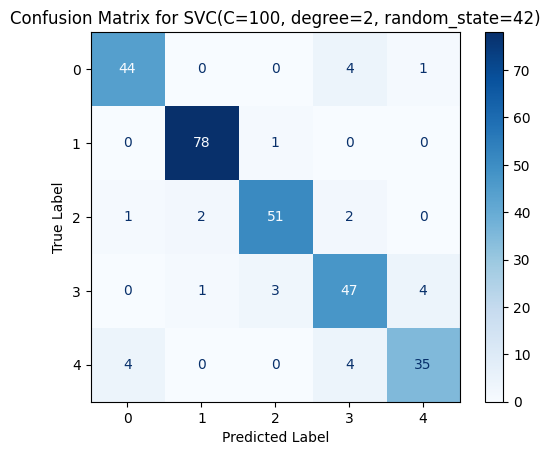

In [ ]:
# Đánh giá mô hình tốt nhất trên tập validation
acc_svm_valid, prec_svm_valid, rec_svm_valid, f1_svm_valid = evaluate_model(grid_svm.best_estimator_, X_valid, y_valid)
print_acc('SVM (Validation)', acc_svm_valid, prec_svm_valid, rec_svm_valid, f1_svm_valid)

# Đánh giá mô hình cuối cùng trên tập test
acc_svm_test, prec_svm_test, rec_svm_test, f1_svm_test = evaluate_model(grid_svm.best_estimator_, X_test, y_test)
print_acc('SVM (Test)', acc_svm_test, prec_svm_test, rec_svm_test, f1_svm_test)

# Vẽ confusion matrix cho tập test
plot_confusion_matrix(grid_svm.best_estimator_, X_test, y_test)

In [ ]:
# Chia toàn bộ dữ liệu thành 10 tập để đánh giá cross-validation
pipeline_svm = Pipeline([
    ('transformer', scaler),
    ('estimator', grid_svm.best_estimator_)
])

cv = KFold(n_splits=10, shuffle=True, random_state=42)
scores_svm = cross_val_score(pipeline_svm, X, y, cv=cv, scoring='accuracy')

print("Cross-validation scores:", scores_svm)
print("Mean accuracy:", scores_svm.mean())
print("Standard deviation:", scores_svm.std())

Cross-validation scores: [0.90106007 0.91519435 0.89361702 0.90780142 0.90780142 0.89716312
 0.89361702 0.90425532 0.89361702 0.89007092]
Mean accuracy: 0.9004197679372478
Standard deviation: 0.007739015347377966


# Decision Tree Classifier

Decision Tree Classifier là một thuật toán học máy đơn giản và được sử dụng rộng rãi trong các bài toán phân loại và hồi quy. Thuật toán này hoạt động bằng cách chia nhỏ tập dữ liệu thành các nhóm dựa trên các thuộc tính, nhằm tối ưu hóa tiêu chí đánh giá chất lượng của từng bước chia (split). Decision Tree có ưu điểm dễ trực quan hóa và giải thích, đồng thời cung cấp sự linh hoạt qua các tham số cấu hình, giúp điều chỉnh cây để phù hợp với dữ liệu và bài toán cụ thể.
Dưới đây là mô tả một số tham số quan trọng trong Decision Tree Classifier:


1.   criterion (Tiêu chí đánh giá):

*   Ý nghĩa: Quy định cách đo lường chất lượng của mỗi lần chia.
*   Các lựa chọn: 'gini', 'entropy', 'log_loss'
*   Mặc định: "gini"

2.   max_depth (Độ sâu tối đa của cây):

*   Ý nghĩa: Hạn chế số lượng mức (level) trong cây để tránh overfitting.
*   Nếu None: Các nút sẽ được mở rộng cho đến khi tất cả lá đều thuần khiết hoặc chứa ít hơn min_samples_split mẫu.
*   Mặc định: None

3.   min_samples_split (Số mẫu tối thiểu để chia):

*   Ý nghĩa: Quy định số lượng mẫu tối thiểu để một nút có thể tiếp tục phân chia.
*   Các lựa chọn: Nếu là số nguyên, số mẫu tối thiểu là giá trị đó. Ngược lại, nếu là số thực (float), đó là tỷ lệ $\text{ceil}(\text{min_samples_split} \times n_{\text{samples}})$
*   Mặc định: 2

4.   min_samples_leaf (Số mẫu tối thiểu tại một lá):

*   Ý nghĩa: Yêu cầu số lượng mẫu tối thiểu tại một lá. Điều này giúp làm mịn mô hình, đặc biệt trong bài toán hồi quy.
*   Các lựa chọn: Nếu là số nguyên, số mẫu tối thiểu tại một lá là giá trị đó. Ngược lại, nếu là số thực (float), đó là tỷ lệ $\text{ceil}(\text{min_samples_leaf} \times n_{\text{samples}})$
*   Mặc định: 1









## Training

In [ ]:
param_grid_tree = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# GridSearch
grid_tree = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_tree, cv=5, scoring='accuracy')

# Đo thời gian huấn luyện
start_time = time.time()
grid_tree.fit(X_train, y_train)
end_time = time.time()

# Tính thời gian huấn luyện
training_time = end_time - start_time

print(f"Best Decision Tree params: {grid_tree.best_params_}\n")
print(f"Thời gian huấn luyện: {training_time:.2f} giây")

Best Decision Tree params: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

Thời gian huấn luyện: 14.78 giây


## Evaluation

Decision Tree (Validation)
 - Accuracy: 0.773851590106007,
 - Precision: 0.7729652446623093,
 - Recall: 0.773851590106007,
 - F1 Score: 0.7732908764617896

Decision Tree (Test)
 - Accuracy: 0.8865248226950354,
 - Precision: 0.8865822283300191,
 - Recall: 0.8865248226950354,
 - F1 Score: 0.8862574047009755



<Figure size 800x600 with 0 Axes>

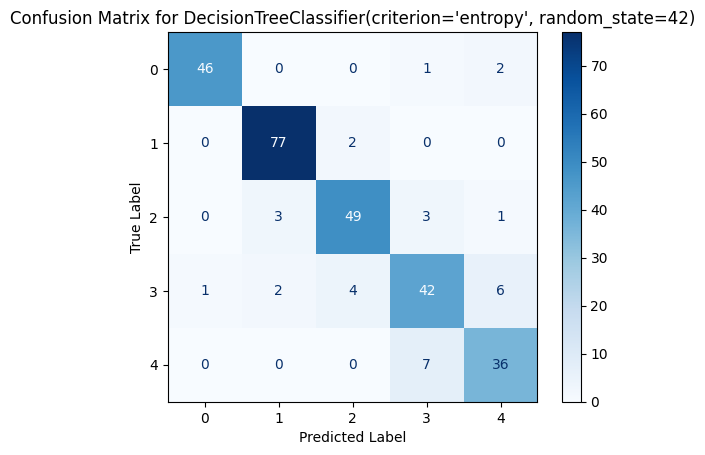

In [ ]:
# Đánh giá mô hình tốt nhất trên tập validation
acc_tree_valid, prec_tree_valid, rec_tree_valid, f1_tree_valid = evaluate_model(grid_tree.best_estimator_, X_valid, y_valid)
print_acc('Decision Tree (Validation)', acc_tree_valid, prec_tree_valid, rec_tree_valid, f1_tree_valid)

# Đánh giá mô hình cuối cùng trên tập test
acc_tree_test, prec_tree_test, rec_tree_test, f1_tree_test = evaluate_model(grid_tree.best_estimator_, X_test, y_test)
print_acc('Decision Tree (Test)', acc_tree_test, prec_tree_test, rec_tree_test, f1_tree_test)

# Vẽ confusion matrix cho tập test
plot_confusion_matrix(grid_tree.best_estimator_, X_test, y_test)

In [ ]:
# Chia toàn bộ dữ liệu thành 10 tập để đánh giá cross-validation
pipeline_tree = Pipeline([
    ('transformer', scaler),
    ('estimator', grid_tree.best_estimator_)
])

cv = KFold(n_splits=10, shuffle=True, random_state=42)
scores_tree = cross_val_score(pipeline_tree, X, y, cv=cv, scoring='accuracy')

print("Cross-validation scores:", scores_tree)
print("Mean accuracy:", scores_tree.mean())
print("Standard deviation:", scores_tree.std())

Cross-validation scores: [0.795053   0.83038869 0.79432624 0.82269504 0.83333333 0.82269504
 0.82269504 0.82978723 0.85106383 0.81205674]
Mean accuracy: 0.8214094178382577
Standard deviation: 0.01641026870354598


# KNN

## Training

In [ ]:
# Tập tham số cho KNN
param_grid_knn = {
    'n_neighbors': [1, 3, 5, 11, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'euclidean', 'manhattan', 'cosine']
}

# GridSearch
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=10, scoring='accuracy')
grid_knn.fit(X_train, y_train)

print(f"Best KNN params: {grid_knn.best_params_}\n")

Best KNN params: {'metric': 'minkowski', 'n_neighbors': 5, 'weights': 'distance'}



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


## Evaluation

KNN (Validation)
 - Accuracy: 0.6925795053003534,
 - Precision: 0.6987050045760625,
 - Recall: 0.6925795053003534,
 - F1 Score: 0.6947820534392972

KNN (Test)
 - Accuracy: 0.7730496453900709,
 - Precision: 0.7715392825685058,
 - Recall: 0.7730496453900709,
 - F1 Score: 0.7706567388161181



<Figure size 800x600 with 0 Axes>

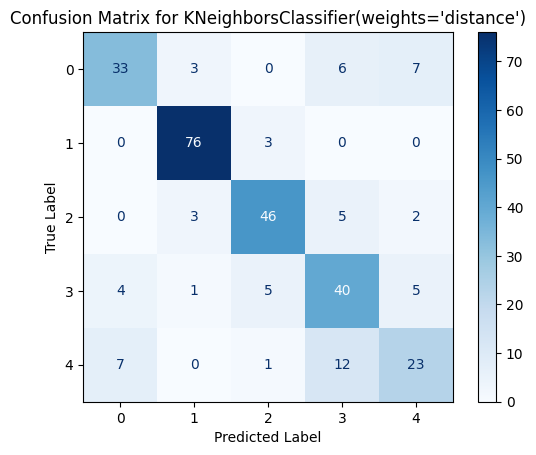

In [ ]:
# Đánh giá mô hình tốt nhất trên tập validation
acc_knn_valid, prec_knn_valid, rec_knn_valid, f1_knn_valid = evaluate_model(grid_knn.best_estimator_, X_valid, y_valid)
print_acc('KNN (Validation)', acc_knn_valid, prec_knn_valid, rec_knn_valid, f1_knn_valid)

# Đánh giá mô hình cuối cùng trên tập test
acc_knn_test, prec_knn_test, rec_knn_test, f1_knn_test = evaluate_model(grid_knn.best_estimator_, X_test, y_test)
print_acc('KNN (Test)', acc_knn_test, prec_knn_test, rec_knn_test, f1_knn_test)

# Vẽ confusion matrix cho tập test
plot_confusion_matrix(grid_knn.best_estimator_, X_test, y_test)

In [ ]:
# Chia toàn bộ dữ liệu thành 10 tập để đánh giá cross-validation
pipeline_knn = Pipeline([
    ('transformer', scaler),
    ('estimator', grid_knn.best_estimator_)
])

cv = KFold(n_splits=10, shuffle=True, random_state=42)
scores_knn = cross_val_score(pipeline_knn, X, y, cv=cv, scoring='accuracy')

print("Cross-validation scores:", scores_knn)
print("Mean accuracy:", scores_knn.mean())
print("Standard deviation:", scores_knn.std())

Cross-validation scores: [0.74911661 0.73144876 0.77659574 0.72695035 0.76241135 0.79078014
 0.71985816 0.75177305 0.74113475 0.74822695]
Mean accuracy: 0.7498295867478635
Standard deviation: 0.02096122720158568


# Random Forest

## Training

In [ ]:
# Tập tham số cho RF
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy'],
}

# GridSearch
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=10, scoring='accuracy')
grid_rf.fit(X_train, y_train)

print(f"Best Random Foreset params: {grid_rf.best_params_}\n")

Best Random Foreset params: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}



## Evaluation

Random Forest (Validation)
 - Accuracy: 0.7879858657243817,
 - Precision: 0.8023602563427111,
 - Recall: 0.7879858657243817,
 - F1 Score: 0.790929312814663

Random Forest (Test)
 - Accuracy: 0.8723404255319149,
 - Precision: 0.8747106154296583,
 - Recall: 0.8723404255319149,
 - F1 Score: 0.8707529942902283



<Figure size 800x600 with 0 Axes>

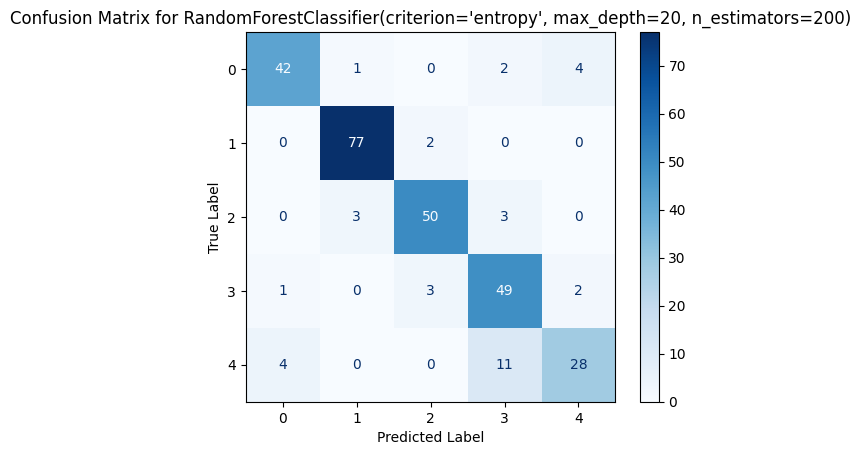

In [ ]:
# Đánh giá mô hình tốt nhất trên tập validation
acc_rf_valid, prec_rf_valid, rec_rf_valid, f1_rf_valid = evaluate_model(grid_rf.best_estimator_, X_valid, y_valid)
print_acc('Random Forest (Validation)', acc_rf_valid, prec_rf_valid, rec_rf_valid, f1_rf_valid)

# Đánh giá mô hình cuối cùng trên tập test
acc_rf_test, prec_rf_test, rec_rf_test, f1_rf_test = evaluate_model(grid_rf.best_estimator_, X_test, y_test)
print_acc('Random Forest (Test)', acc_rf_test, prec_rf_test, rec_rf_test, f1_rf_test)

# Vẽ confusion matrix cho tập test
plot_confusion_matrix(grid_rf.best_estimator_, X_test, y_test)

In [ ]:
# Chia toàn bộ dữ liệu thành 10 tập để đánh giá cross-validation
pipeline_rf = Pipeline([
    ('transformer', scaler),
    ('estimator', grid_rf.best_estimator_)
])

cv = KFold(n_splits=10, shuffle=True, random_state=42)
scores_rf = cross_val_score(pipeline_rf, X, y, cv=cv, scoring='accuracy')

print("Cross-validation scores:", scores_rf)
print("Mean accuracy:", scores_rf.mean())
print("Standard deviation:", scores_rf.std())

Cross-validation scores: [0.86572438 0.83392226 0.80851064 0.81205674 0.84751773 0.84397163
 0.81914894 0.81914894 0.80496454 0.86879433]
Mean accuracy: 0.8323760118286845
Standard deviation: 0.02210940337570801


# LightGBM

LightGBM là một thuật toán học máy mạnh mẽ, thường được sử dụng cho các bài toán phân loại và hồi quy với dữ liệu lớn và phức tạp. Nó nổi bật nhờ hiệu suất cao, khả năng xử lý dữ liệu mất cân bằng tốt và hỗ trợ tùy chỉnh nhiều tham số:

1. **n_estimators** (Số lượng cây con):
- Ý nghĩa: Xác định số lượng cây con trong mô hình. Số lượng cây lớn thường làm tăng hiệu suất nhưng cũng làm tăng thời gian huấn luyện.
- Dữ liệu lớn, phức tạp → giá trị cao hơn (200-500) để đảm bảo hội tụ.
- Dữ liệu vừa phải → giá trị thấp hơn (100-200) để tối ưu thời gian tính toán.
2. **learning_rate** (Tốc độ học):
Ý nghĩa: Quy định mức độ điều chỉnh trọng số sau mỗi lần cập nhật.
- Các lựa chọn: [0.01, 0.1, 0.2]
- Mặc định: 0.1
- Dữ liệu nhiễu hoặc nhiều mối quan hệ phức tạp → giá trị nhỏ (0.01-0.05) để mô hình hội tụ từ từ.
- Dữ liệu dễ phân tách hoặc ít nhiễu → giá trị lớn hơn (0.1-0.2) giúp tăng tốc độ hội tụ.
3. **max_depth** (Độ sâu tối đa của cây):
- Ý nghĩa: Giới hạn số mức (level) tối đa trong mỗi cây con.
- Các lựa chọn: [10, 20, 30]
- Mặc định: -1 (không giới hạn)
- Dữ liệu có nhiều mẫu và đặc trưng, các mối quan hệ phức tạp → giá trị lớn (15-30).
- Dữ liệu nhỏ hoặc đơn giản → giá trị nhỏ (5-10) để giảm overfitting.
4. **num_leaves** (Số lá tối đa):
- Ý nghĩa: Quy định số lượng lá tối đa trong một cây.
- Các lựa chọn: [50, 100]
- Mặc định: 31
- Dữ liệu lớn và phức tạp → giá trị cao (50-100).
- Dữ liệu nhỏ → giá trị thấp hơn (20-40) để giữ tính tổng quát.
5. **min_split_gain** (Lợi nhuận tối thiểu để chia):
- Ý nghĩa: Quy định lợi nhuận tối thiểu cần đạt để tiếp tục chia nút.
- Các lựa chọn: [0.01, 0.1, 1]
- Mặc định: 0.0
- Dữ liệu phức tạp với nhiều mối quan hệ nhỏ cần học → giá trị nhỏ (0.01-0.1).
- Dữ liệu ít nhiễu hoặc không cần chi tiết quá mức → giá trị lớn hơn (0.5-1.0).
6. **colsample_bytree** (Tỷ lệ cột lấy mẫu cho mỗi cây):
- Ý nghĩa: Tỷ lệ các cột được chọn ngẫu nhiên để xây dựng mỗi cây con.
- Các lựa chọn: [0.8, 1.0]
- Mặc định: 1.0
- Dữ liệu có nhiều đặc trưng dư thừa hoặc tương quan mạnh giữa các đặc trưng → giá trị nhỏ (0.8-0.9) phù hợp.
- Dữ liệu ít đặc trưng quan trọng và tất cả các đặc trưng đều ảnh hưởng lớn → giá trị gần 1.0 phù hợp.
7. **subsample** (Tỷ lệ mẫu lấy để xây dựng mỗi cây):
- Ý nghĩa: Tỷ lệ các mẫu dữ liệu được chọn ngẫu nhiên để xây dựng mỗi cây con.
- Các lựa chọn: [0.8, 1.0]
- Mặc định: 1.0
- Dữ liệu lớn với nhiều mẫu → giá trị nhỏ hơn (0.7-0.9).
- Dữ liệu nhỏ hoặc ít mẫu → giá trị gần 1.0 để tận dụng toàn bộ dữ liệu.
8. **min_child_samples** (Số mẫu tối thiểu để chia một nút):
- Ý nghĩa: Quy định số lượng mẫu tối thiểu cần thiết để một nút được chia.
- Các lựa chọn: [40, 80]
- Mặc định: 20
- Dữ liệu có nhiều nhiễu hoặc mất cân bằng lớp → giá trị lớn (40-80) giúp cây ổn định hơn.
- Dữ liệu cân bằng và ít nhiễu → giá trị nhỏ hơn (20-30) để mô hình học chi tiết hơn.

## Training

In [ ]:
param_grid_lgbm = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [10, 20, 30],
    'num_leaves': [50, 100],
    'min_split_gain': [0.01, 0.1, 1],
    'colsample_bytree': [0.8, 1.0],
    'subsample': [0.8, 1.0],
    'min_child_samples': [40, 80]
}

In [ ]:
grid_lgbm = GridSearchCV(estimator=LGBMClassifier(random_state=42,verbose = -1), param_grid=param_grid_lgbm, cv=5, scoring='accuracy', n_jobs=-1)
grid_lgbm.fit(X_train, y_train)

print(f"Best LightGBM params: {grid_lgbm.best_params_}\n")

Best LightGBM params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 20, 'min_child_samples': 40, 'min_split_gain': 0.01, 'n_estimators': 100, 'num_leaves': 50, 'subsample': 0.8}



## Evaluation

LightGBM (Validation)
 - Accuracy: 0.8056537102473498,
 - Precision: 0.8118784882806244,
 - Recall: 0.8056537102473498,
 - F1 Score: 0.8059049802414455

LightGBM (Test)
 - Accuracy: 0.9113475177304965,
 - Precision: 0.9114213947990545,
 - Recall: 0.9113475177304965,
 - F1 Score: 0.9113564847195609



<Figure size 800x600 with 0 Axes>

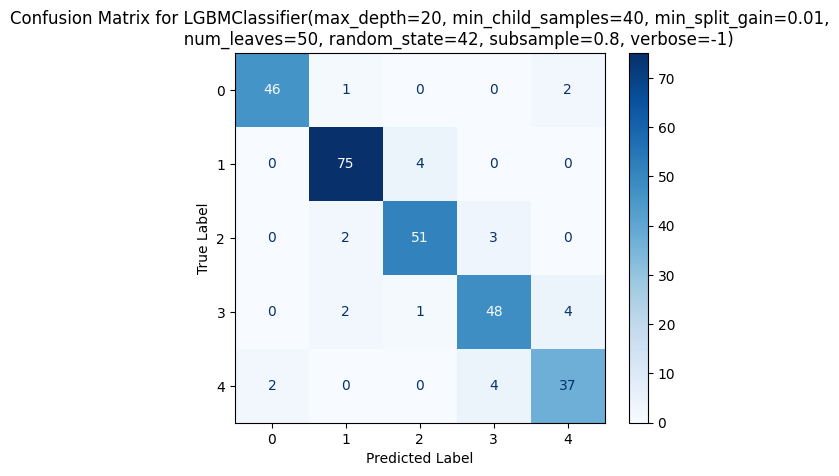

In [ ]:
acc_lgbm_valid, prec_lgbm_valid, rec_lgbm_valid, f1_lgbm_valid = evaluate_model(grid_lgbm.best_estimator_, X_valid, y_valid)
print_acc('LightGBM (Validation)', acc_lgbm_valid, prec_lgbm_valid, rec_lgbm_valid, f1_lgbm_valid)

acc_lgbm_test, prec_lgbm_test, rec_lgbm_test, f1_lgbm_test = evaluate_model(grid_lgbm.best_estimator_, X_test, y_test)
print_acc('LightGBM (Test)', acc_lgbm_test, prec_lgbm_test, rec_lgbm_test, f1_lgbm_test)

plot_confusion_matrix(grid_lgbm.best_estimator_, X_test, y_test)

In [ ]:
pipeline_lgbm = Pipeline([
    ('transformer', scaler),
    ('estimator', grid_lgbm.best_estimator_)
])

In [ ]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)
scores_lgbm = cross_val_score(pipeline_lgbm, X, y, cv=cv, scoring='accuracy')

In [ ]:
print("Cross-validation scores:", scores_lgbm)
print("Mean accuracy:", scores_lgbm.mean())
print("Standard deviation:", scores_lgbm.std())

Cross-validation scores: [0.86925795 0.85159011 0.85106383 0.85815603 0.86879433 0.87588652
 0.85106383 0.85460993 0.85815603 0.86879433]
Mean accuracy: 0.8607372879232138
Standard deviation: 0.008681161515749946


# CatBoost

CatBoostClassifier là một thuật toán tăng cường độ dốc (Gradient Boosting) tối ưu, được thiết kế để hoạt động tốt với dữ liệu phân loại và dữ liệu mất cân bằng. Nhờ khả năng tự động xử lý các đặc trưng danh mục (categorical features) và giảm thiểu overfitting, CatBoost được đánh giá cao về hiệu suất và tính dễ sử dụng. Dưới đây là phân tích chi tiết các tham số mà nhóm sử dụng:

1. **iterations** (Số vòng lặp huấn luyện):
- Ý nghĩa: Quy định số lượng cây được xây dựng trong mô hình.
- Các lựa chọn: [100, 200, 300, 500]
- Mặc định: 500
- Cách hoạt động: Số vòng lặp lớn hơn thường cải thiện hiệu suất của mô hình, nhưng cũng tăng thời gian huấn luyện và nguy cơ overfitting.
- Dữ liệu lớn và phức tạp → giá trị cao hơn (300).
- Dữ liệu nhỏ hoặc đơn giản → giá trị thấp hơn (100-150) đủ để hội tụ.
2. **learning_rate** (Tốc độ học):
- Ý nghĩa: Quy định mức độ điều chỉnh trọng số sau mỗi lần cập nhật.
- Các lựa chọn: [0.01, 0.05, 0.1]
- Mặc định: 0.03
- Cách hoạt động: Giá trị nhỏ hơn giúp mô hình học chậm nhưng chính xác hơn, giảm nguy cơ overfitting. Giá trị lớn hơn tăng tốc độ hội tụ nhưng dễ làm mất ổn định mô hình. Nên kết hợp với số vòng lặp thích hợp.
- Dữ liệu nhiễu hoặc có mối quan hệ phức tạp → giá trị nhỏ (0.01-0.05).
- Dữ liệu ít nhiễu hoặc dễ phân tách → giá trị lớn hơn (0.1-0.2).
3. **depth** (Độ sâu của cây con):
- Ý nghĩa: Quy định số mức tối đa của mỗi cây con.
- Các lựa chọn: [4, 6, 8, 10]
- Mặc định: 6
- Cách hoạt động: Độ sâu lớn hơn cho phép cây con học được nhiều chi tiết hơn, nhưng dễ gây overfitting. Độ sâu nhỏ hơn cải thiện khả năng tổng quát hóa, nhưng có thể bỏ qua các thông tin quan trọng. Giá trị lý tưởng phụ thuộc vào độ phức tạp của dữ liệu
- Dữ liệu nhiều đặc trưng và phức tạp → giá trị cao hơn (8).
- Dữ liệu ít đặc trưng hoặc đơn giản → giá trị nhỏ hơn (6) để tránh overfitting.


## Training

In [ ]:
param_grid_cb = {
    'iterations': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'depth': [4, 6, 8, 10]
}

In [ ]:
grid_cb = GridSearchCV(estimator=CatBoostClassifier(silent=True, random_state=42), param_grid=param_grid_cb, cv=5, scoring='accuracy', n_jobs=-1)
grid_cb.fit(X_train, y_train)

print(f"Best CatBoost params: {grid_cb.best_params_}\n")

Best CatBoost params: {'depth': 8, 'iterations': 300, 'learning_rate': 0.1}



## Evaluation

CatBoost (Validation)
 - Accuracy: 0.8197879858657244,
 - Precision: 0.8298397794668452,
 - Recall: 0.8197879858657244,
 - F1 Score: 0.822446117499121

CatBoost (Test)
 - Accuracy: 0.900709219858156,
 - Precision: 0.9034977053244132,
 - Recall: 0.900709219858156,
 - F1 Score: 0.9014551525715895



<Figure size 800x600 with 0 Axes>

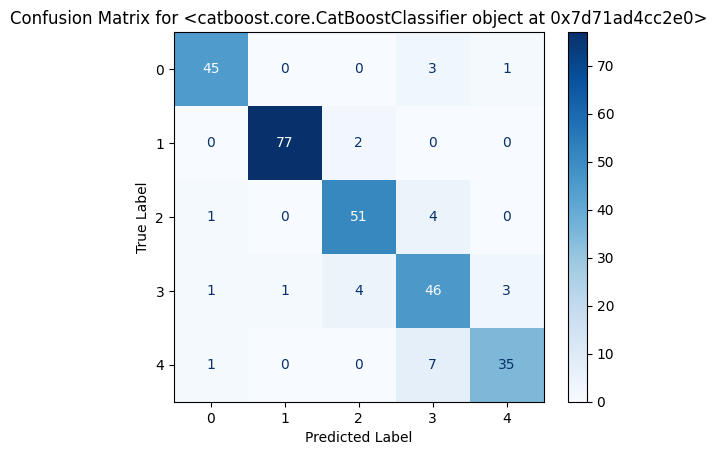

In [ ]:
acc_cb_valid, prec_cb_valid, rec_cb_valid, f1_cb_valid = evaluate_model(grid_cb.best_estimator_, X_valid, y_valid)
print_acc('CatBoost (Validation)', acc_cb_valid, prec_cb_valid, rec_cb_valid, f1_cb_valid)

acc_cb_test, prec_cb_test, rec_cb_test, f1_cb_test = evaluate_model(grid_cb.best_estimator_, X_test, y_test)
print_acc('CatBoost (Test)', acc_cb_test, prec_cb_test, rec_cb_test, f1_cb_test)

plot_confusion_matrix(grid_cb.best_estimator_, X_test, y_test)

In [ ]:
pipeline_cb = Pipeline([
    ('transformer', scaler),
    ('estimator', grid_cb.best_estimator_)
])

In [ ]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)
scores_cb = cross_val_score(pipeline_cb, X, y, cv=cv, scoring='accuracy')

In [ ]:
print("Cross-validation scores:", scores_cb)
print("Mean accuracy:", scores_cb.mean())
print("Standard deviation:", scores_cb.std())

Cross-validation scores: [0.89045936 0.87985866 0.84397163 0.86879433 0.90780142 0.88652482
 0.87943262 0.86170213 0.89007092 0.87234043]
Mean accuracy: 0.8780956319073754
Standard deviation: 0.01675554043575359


# Evaluation

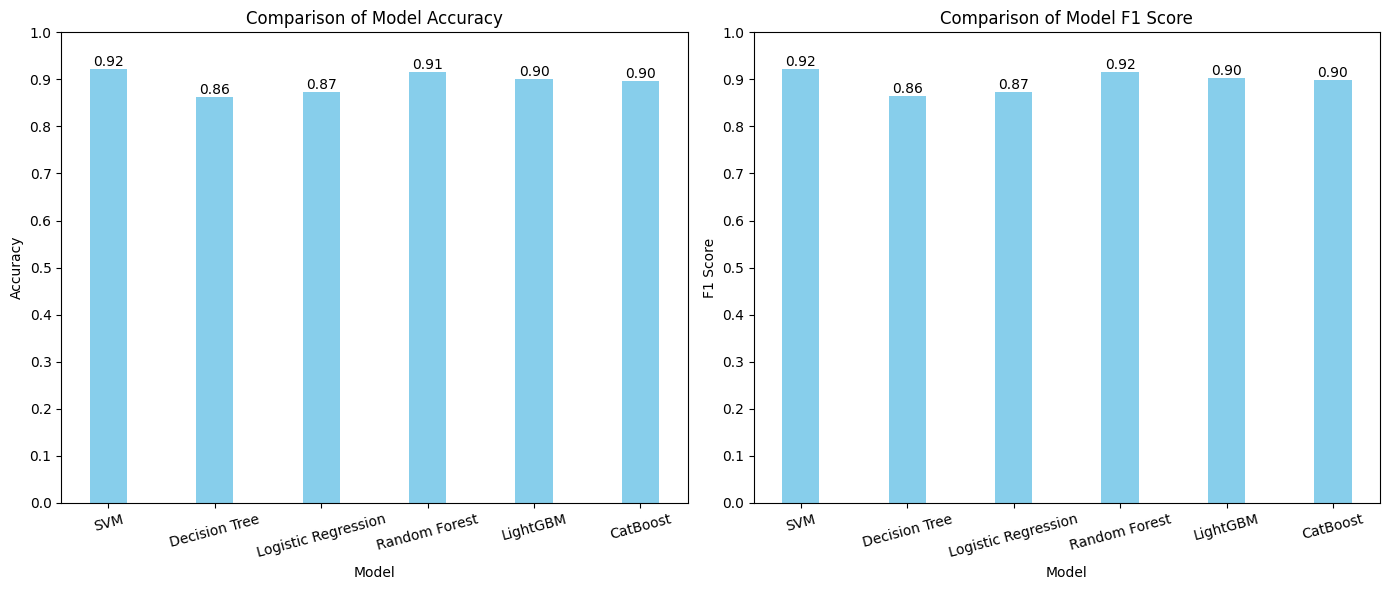

In [ ]:
models = ['SVM', 'Decision Tree', 'Logistic Regression', 'Random Forest', 'LightGBM', 'CatBoost']
acc = [acc_svm_test, acc_tree_test, acc_logreg_test, acc_rf_test, acc_lgbm_test, acc_cb_test]
f1 = [f1_svm_test, f1_tree_test, f1_logreg_test, f1_rf_test, f1_lgbm_test, f1_cb_test]

bar_width = 0.35
index = np.arange(len(models))

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
colors = ['skyblue'] * len(models)
plt.bar(index, acc, bar_width, color=colors)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracy')
plt.xticks(index, models, rotation=15)
plt.yticks(np.arange(0, 1.1, 0.1))
for i in range(len(models)):
    plt.text(i, acc[i], f'{acc[i]:.2f}', ha='center', va='bottom', color='black')

plt.subplot(1, 2, 2)
plt.bar(index, f1, bar_width, color=colors)
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('Comparison of Model F1 Score')
plt.xticks(index, models, rotation=15)
plt.yticks(np.arange(0, 1.1, 0.1))
for i in range(len(models)):
    plt.text(i, f1[i], f'{f1[i]:.2f}', ha='center', va='bottom', color='black')

plt.tight_layout()
plt.show()

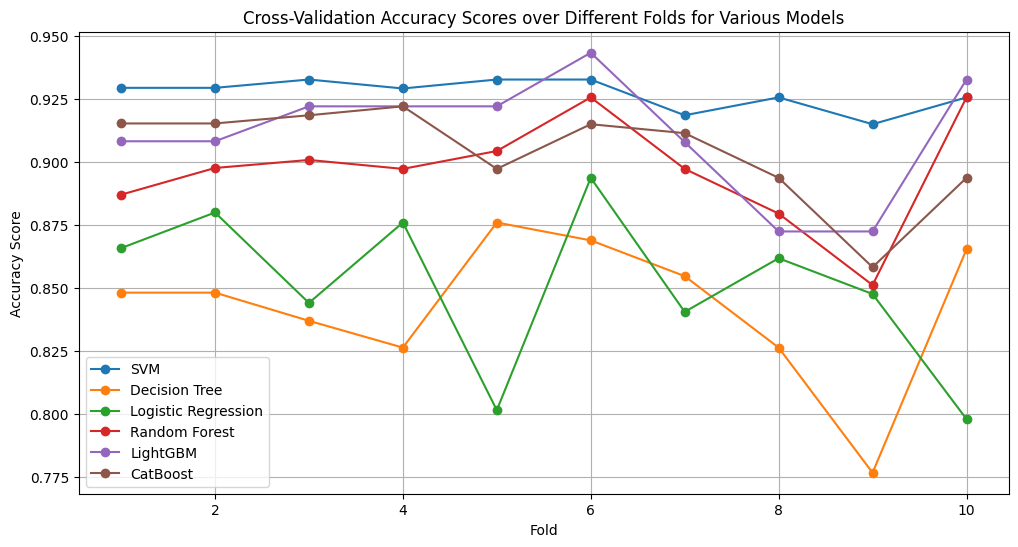

In [ ]:
models = ['SVM', 'Decision Tree', 'Logistic Regression', 'Random Forest', 'LightGBM', 'CatBoost']
all_scores = [scores_svm, scores_tree, scores_lr, scores_rf, scores_lgbm, scores_cb]

# Plotting
plt.figure(figsize=(12, 6))
for i, scores in enumerate(all_scores):
    plt.plot(range(1, len(scores) + 1), scores, marker='o', label=models[i])

plt.xlabel("Fold")
plt.ylabel("Accuracy Score")
plt.title("Cross-Validation Accuracy Scores over Different Folds for Various Models")
plt.legend()
plt.grid(True)
plt.show()